<a href="https://colab.research.google.com/github/ialara/actf/blob/f35-excursion/f35_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Guts

In [125]:
import numpy as np
from collections import Counter
import copy
import matplotlib.pyplot as plt
import matplotlib.ticker
import seaborn as sns
import pandas as pd
rng = np.random.default_rng()

class Pilot:
    ftu_sorties = 39 # Sortie Flow F-35 xlsx
    def __init__(self, i, mds_sorties=59, tos=0, experienced=False):
        self.id = i
        self.mds_sorties = mds_sorties
        self.tos = tos
        self.experienced = experienced
        self.arrived_month = 0
        self.in_ug = False
        self.ug = None
        self.ride_num = None
        self.quals = []
        self.tte = 0

    def set_arrived_month(self, month):
        self.arrived_month = month

    def increment_tos(self, months=1):
        self.tos += months

    def increment_mds_sorties(self, sortie_increment=1):
        self.mds_sorties += sortie_increment
        if self.in_ug:
          self.ride_num += sortie_increment

    def enroll_in_ug(self, ug, start_month=0):
        if self.in_ug:
            #print(f'PID {self.id} already enrolled in {self.ug}. {f"Did not enroll in {ug}." if self.ug != ug else ""}')
            return
        self.in_ug = True
        self.ug = ug
        self.ug_start_month = start_month
        self.ride_num = 0
        #print(f'PID {self.id} enrolled in {self.ug}.')
      
    def disenroll_from_ug(self):
        self.in_ug = False
        self.ug = None
        self.ride_num = None

    def award_qual(self, qual):
        if qual not in self.quals:
            self.quals.append(qual)

    def print_(self):
        msg = [f'ID: {self.id:2d} | EXP: {"Y" if self.experienced else "N"} | ',
               f'TOS: {self.tos:2d} | STY: {self.mds_sorties:3d} | ARR: {self.arrived_month:3d} | ',
               f'TTE: {self.tte if self.experienced else "- ":2} | QUAL: {self.quals}']
        if self.ug is not None:
            msg.append(f' | UG: {self.ug} #{self.ride_num}')

        print(*msg)

class Squadron:
    def __init__(self, name='default_Squadron', syllabi=None):
        self.name = name
        self.pilots = []
        self.gone_pilots = []
        self.absorbed_pilots = []
        self.pid = 0
        if syllabi is None:
            self.syllabi = {}
        else:
            self.syllabi = syllabi

    def assign_pilot(self, pilot, arrived_month=0):
        self.pilots.append(pilot)
        pilot.set_arrived_month(arrived_month)

    def add_syllabi(self, syllabi):
        self.syllabi = syllabi

    def set_syllabus_ug_capacity(self, syllabus, capacity):
        syllabus.capacity = capacity

    def set_monthly_sorties_available(self, capacity=240):
        self.monthly_sorties_available = capacity

    def _next_pid(self):
        self.pid += 1
        return self.pid

    def get_pilot_by_id(self, id):
        pilot_dict = {p.id: p for p in self.pilots}
        pilot_dict.update({p.id: p for p in self.gone_pilots})
        return pilot_dict[id]

    def get_pilots_by_qual(self):
        quals = np.asarray(self._get_highest_quals())
        pilots = np.asarray(self.pilots)
      
        return {q: list(pilots[quals == q]) for q in Counter(quals).keys()}


    def populate_initial(self, num_pilots=36, prop_EXP=0.6, prop_IP=0.3):
        # num_EXP = rng.binomial(num_pilots, prop_EXP)
        # num_IP = rng.binomial(num_EXP, prop_IP)
        # num_INX = num_pilots - num_EXP

        num_EXP = int(num_pilots*prop_EXP) # API-1 45% EXP x 26 pilots + API-6 100% EXP x 10 pilots
        num_IP = int(num_pilots*prop_IP)
        num_INX = num_pilots - num_EXP

        # Parameters
        min_TOS_INX = 0
        max_TOS_INX = 37
        min_TOS_EXP = 0
        max_TOS_EXP = 37

        min_sorties_INX = Pilot.ftu_sorties
        max_sorties_INX = 250 # Syllabus.exp_sortie_rqmt < BREAKS EXCURSIONS removing/lessening sortie rqmts
        min_sorties_EXP = 250 # Syllabus.exp_sortie_rqmt
        max_sorties_EXP = 600 # 2*Syllabus.exp_sortie_rqmt

        # Assign INX pilots
        for _ in range(num_INX):
            my_tos = rng.integers(min_TOS_INX, max_TOS_INX)
            my_sorties = rng.integers(min_sorties_INX, max_sorties_INX)
            # Rough capping of sorties w/ TOS: Assume no more than 9 sorties per month
            # (Assume no "holdover" INX arrivals in initial population)
            my_sorties = min(my_sorties, min_sorties_INX + (my_tos+1)*9)
            inx_pilot = Pilot(self._next_pid(), mds_sorties=my_sorties, tos=my_tos)
            inx_pilot.initial_tos = my_tos # Debugging initial population

            inx_pilot.inflow_source = 'initial'
            inx_pilot.absorbable = True
            if inx_pilot.tos > 2: # Assume initial population completes MQT in specified timeline, and represents only first tour arrivals
                inx_pilot.increment_mds_sorties(self.syllabi['MQT'].duration) # Duration of MQT
                inx_pilot.award_qual(self.syllabi['MQT'].award)
                inx_pilot.inflow_source += f' {self.syllabi["MQT"].award}'

                # two_fl_draw = rng.random()
                # if inx_pilot.mds_sorties >= 150 and two_fl_draw < min(.5+int((inx_pilot.mds_sorties-150)/30)*.15, 0.99):
                #     inx_pilot.award_qual(self.syllabi['2FLUG'].award)
                #     inx_pilot.inflow_source += f'/{self.syllabi["2FLUG"].award}'

            else: # These are new arrivals - assume all initial INX with 0 or 1 TOS
                  # are from FTU
                my_ug_prog = rng.integers(self.syllabi['MQT'].duration) # MQT and FLUG have same duration
                # Assumptions: INX arrivals with 0 or 1 TOS are either new from FTU,
                # or "hold-overs" arriving INX from previous location
                ##if inx_pilot.f16_sorties < 75:
                inx_pilot.enroll_in_ug('MQT')
                #self.syllabi['MQT'].capacity -= 1
                inx_pilot.increment_mds_sorties(my_ug_prog)
                # elif inx_pilot.f16_sorties < 200:
                #     inx_pilot.award_qual('WG')
                #     inx_pilot.inflow_source += ' WG'
                #     if rng.random() < 0.7:
                #         inx_pilot.enroll_in_ug('FLUG')
                #         #self.syllabi['FLUG'].capacity -= 1
                #         inx_pilot.increment_f16_sorties(my_ug_prog)
                #         inx_pilot.inflow_source += '/FLUG'

                # else:
                #     inx_pilot.award_qual('WG')
                #     if rng.random() < 0.7:
                #         inx_pilot.award_qual('FL')
                #         inx_pilot.inflow_source += ' FL'
            self.assign_pilot(inx_pilot, arrived_month=-1*inx_pilot.tos)
          
        # Assign EXP pilots
        ips_remaining = num_IP
        for _ in range(num_EXP):
            my_tos = rng.integers(min_TOS_EXP, max_TOS_EXP)
            my_sorties = rng.integers(min_sorties_EXP, max_sorties_EXP)
            exp_pilot = Pilot(self._next_pid(), mds_sorties=my_sorties, tos=my_tos,
                              experienced = True)
            exp_pilot.award_qual(Syllabus.exp_qual_rqmt)
            exp_pilot.absorbable = False
            if exp_pilot.mds_sorties >= 284 and ips_remaining > 0: #275 based on Slab desired changes + 9 for IPUG -- make a parameter
                exp_pilot.award_qual('IP')
                ips_remaining -= 1
            # elif exp_pilot.f16_sorties >= 275:
            #     ipug_prob = min(1, 0.6 + int((exp_pilot.f16_sorties - 275)/30)*.15)
            #     if rng.random() < ipug_prob:
            #       exp_pilot.enroll_in_ug('IPUG')
            #       #self.syllabi['IPUG'].capacity -= 1
            #       exp_pilot.increment_f16_sorties(rng.integers(9))
            exp_pilot.initial_tos = my_tos
            self.assign_pilot(exp_pilot, arrived_month=-1*exp_pilot.tos)

    def inflow_from_ftu(self, num_pilots=15, arrival_month=0):
        new_ftus = []
        for _ in range(num_pilots):
            ftu_sortie_delta = rng.integers(-5, 5)
            my_mds_sorties = Pilot.ftu_sorties + ftu_sortie_delta
            new_pilot = Pilot(self._next_pid(), mds_sorties = my_mds_sorties)
            new_pilot.inflow_source = 'FTU'
            new_pilot.absorbable = True
            self.assign_pilot(new_pilot, arrived_month=arrival_month)
            new_ftus.append(new_pilot)
        
        return new_ftus

    def inflow_nth_tour(self, num_pilots=20, prop_IP=0.2, prop_WG=0.5, arrival_month=0):
        num_IP = rng.binomial(num_pilots, prop_IP)
        num_WG = rng.binomial(num_pilots, prop_WG)
        num_FL = num_pilots - num_IP - num_WG

        # Parameters
        min_sorties_WG = 200 # BREAKS EXCURSIONS changing sortie rqmt --> int(0.8*Syllabus.exp_sortie_rqmt)
        max_sorties_WG = 240 # (0.9*Syllabus.exp_sortie_rqmt)
        min_sorties_FL = 240 # int(0.9*Syllabus.exp_sortie_rqmt)
        max_sorties_FL = 500 # int(2*Syllabus.exp_sortie_rqmt)
        min_sorties_IP = 375 # int(1.5*Syllabus.exp_sortie_rqmt)
        max_sorties_IP = 1000 # 4*Syllabus.exp_sortie_rqmt

        new_nth = []
        for _ in range(num_IP):
            my_sorties = rng.integers(min_sorties_IP, max_sorties_IP)
            new_IP = Pilot(self._next_pid(), mds_sorties = my_sorties, experienced=True)
            new_IP.award_qual(Syllabus.exp_qual_rqmt)
            new_IP.award_qual('IP')
            self.assign_pilot(new_IP, arrived_month=arrival_month)
            new_IP.absorbable = False
            new_nth.append(new_IP)

        for _ in range(num_FL):
            my_sorties = rng.integers(min_sorties_FL, max_sorties_FL)
            new_FL = Pilot(self._next_pid(), mds_sorties = my_sorties)
            new_FL.award_qual('FL')
            new_FL.experienced = Syllabus.meets_EXP_criteria(new_FL.mds_sorties, new_FL.quals)
            new_FL.inflow_source = 'nth tour'
            self.assign_pilot(new_FL, arrived_month=arrival_month)
            new_FL.absorbable = False
            new_nth.append(new_FL)

        for _ in range(num_WG):
            my_sorties = rng.integers(min_sorties_WG, max_sorties_WG)
            new_WG = Pilot(self._next_pid(), mds_sorties = my_sorties)
            new_WG.award_qual('WG')
            new_WG.inflow_source = 'nth tour'
            new_WG.absorbable = False
            self.assign_pilot(new_WG, arrived_month=arrival_month)
            new_nth.append(new_WG)
        
        return new_nth
            
    def inflow_pilots(self, num_ftu=15, num_nth_tour=5, arrival_month=0):
        new_ftus = self.inflow_from_ftu(num_ftu, arrival_month=arrival_month)
        new_nth = self.inflow_nth_tour(num_nth_tour, arrival_month=arrival_month)
        try:
            ips = self.get_pilots_by_qual()['IP']
            for p in ips:
                assert p.experienced, f'IP {p.id} is not experienced.'
        except KeyError:
             pass
        return new_ftus, new_nth

    def outflow_pilots(self, tos_threshold=36):
        removed_pilots = [p for p in self.pilots if p.tos >= tos_threshold]
        for p in removed_pilots:
            if p.absorbable:
                p.absorbed = False
        self.pilots = [p for p in self.pilots if p not in set(removed_pilots)]
        self.gone_pilots.extend(removed_pilots)
        return removed_pilots

    def enroll_ug_students(self, start_month=0):
        pilots_by_quals = self.get_pilots_by_qual()
        def _find_candidates(qual_prereq):
            candidates = []
            try:
                candidates = pilots_by_quals[qual_prereq]
            except KeyError:
                #print(f'Could not find any {qual_prereq}. Returning: {candidates}')
                pass
            return candidates

        mqt_candidates = _find_candidates('')
        flug_candidates = _find_candidates(self.syllabi['MQT'].award)
        flug_candidates = [p for p in flug_candidates if p.mds_sorties >= 195 and rng.random() < min(.5+int((p.mds_sorties-195)/30)*.15, 0.99)]
        ipug_candidates = _find_candidates(self.syllabi['FLUG'].award)
        ipug_candidates = [p for p in ipug_candidates if p.experienced and p.mds_sorties >= 275 and rng.random() < min(.5+int((p.mds_sorties-275)/30)*.15, 0.99)]
            
        # Prioritize students (e.g. by TOS for MQT; sorties for FLUG/IPUG)
        mqt_candidates.sort(key=lambda x: (x.tos, x.mds_sorties), reverse=True)
        flug_candidates.sort(key=lambda x: x.mds_sorties, reverse=True)
        ipug_candidates.sort(key=lambda x: x.mds_sorties, reverse=True)
        # Enroll as many as possible, subject to capacity of upgrade program
        for students, program in zip([mqt_candidates, flug_candidates, ipug_candidates],
                                     [self.syllabi['MQT'], self.syllabi['FLUG'], self.syllabi['IPUG']]):
          # TODO: Note this is not guaranteed if programs have different capacities
          # (self.syllabi.values() order returned is random)
            enrollees = students[:program.capacity]
            for e in enrollees:
              e.enroll_in_ug(program.name, start_month=start_month)

    def fly_month(self, sorties_available=None, INX_tails_pct=0.3, fly_days=20):
        if sorties_available is None:
            sorties_available = self.monthly_sorties_available
        #INX_sorties = int(sorties_available * INX_sortie_pct)
        INX_pilots = [p for p in self.pilots if not p.experienced]

        for p in self.pilots:
            p.scm = 0

        rng.shuffle(INX_pilots)
        sorties_remaining = sorties_available
        inx_sorties_flown = 0
        inx_support_sorties_flown = 0
        # Essentially the theoretical SCM limit, accounting for student non-availability
        daily_inx_tails = min(len(INX_pilots), int((sorties_available / fly_days)*INX_tails_pct)) # Up to INX_tails_pct proportion of PMAI dedicated to absorbing pilot (MQT or WG).
        
        # print("FLY MONTH")
        # for k,v in self.get_pilots_by_qual().items():
        #     print(f'{k}: {[p.id for p in v]}')
        for p in INX_pilots:
            fls = []
            try:
                fls = self.get_pilots_by_qual()['FL']
            except KeyError:
                # print("@@@ KEY ERROR FOR FLs")
                fls = fls
            try:
                ips = self.get_pilots_by_qual()['IP']
            except KeyError:
                ips = []
            support_pool = fls + ips 
            support_pool = [spt for spt in support_pool if spt.id != p.id] # Cannot be own support
          # TODO: Confirm statistical correctness (probability and use of binomial)
          # Logic: 20 fly days per monthcalc
          # Assuming 10-turn-8 pattern, and each INX needing supervision,
          # 9 tails assignable to INX each day.
          # Even probability of assignment per student means p = 9 / num_INX.
            my_draw = rng.binomial(max(fly_days - p.scm, 0), min(daily_inx_tails / len(INX_pilots), 0.99))
            my_SCM = max(min(my_draw, sorties_available), 0)
            p.scm = my_SCM
            #print(f'PID {p.id:2d}: drew {my_draw:2d}, flying {my_SCM:2d}. p.scm: {p.scm}')
            p.increment_mds_sorties(p.scm)
            # Increment for IPs/FLs
            if p.in_ug: # Can be either MQT or FLUG. UGs require IP supervision.
                if len(ips) > 0:
                    support_flown = rng.choice(ips, size=p.scm)
                    assert p.id not in set([spt.id for spt in support_flown]), f'Cannot be own support for PID {p.id}'
                else:
                    # No IPs available, no upgrades can happen
                    support_flown = []
                    # "Undo" scm assignment
                    p.increment_mds_sorties(-1*p.scm)
                    p.scm = 0
            elif self._get_highest_quals(pilots=[p]) == ['WG']: # This is a non-FLUG WG. Supervisable by any FL+.
                # try:
                #     support_pool = self.get_pilots_by_qual()['FL']
                # except KeyError:
                #     support_pool = self.get_pilots_by_qual()['IP']
                support_flown = rng.choice(support_pool, size=p.scm)
            else:
                support_flown = []
                assert p.id not in set([spt.id for spt in support_flown]), f'Cannot be own support for PID {p.id}'
            for support_pilot in support_flown:
                assert support_pilot.id != p.id, f'Cannot be own support for PID {p.id}'
                while support_pilot.scm > fly_days - 1: # Avoid exceeding 1 sortie per month per pilot
                    support_pilot = rng.choice(support_pool)
                support_pilot.increment_mds_sorties()
                support_pilot.scm += 1
                inx_support_sorties_flown += 1
                sorties_remaining -= 1           
            sorties_remaining -= p.scm
            inx_sorties_flown += p.scm
            
        #print(*[f'{p.id}: {p.scm} | ' for p in INX_pilots])

        EXP_pilots = [p for p in self.pilots if p.experienced]
        EXP_sorties = max(sorties_remaining, 0)
        non_absorption_sorties = 0
        for p in EXP_pilots:
            assert p.id not in set([inx.id for inx in INX_pilots]), 'Pilot cannot be INX and EXP'
            my_draw = rng.binomial(max(fly_days - p.scm, 0), min(len(EXP_pilots), ((sorties_available / fly_days) - 2*daily_inx_tails)) / len(EXP_pilots)) # <- 2x because absorption sorties require minimum 2 jets. 1 for UP and 1 for supervisor/IP.
            my_SCM = max(min(my_draw, sorties_remaining), 0)
            #print(f'PID {p.id:2d}: drew {my_draw:2d}, flying {my_SCM:2d}.')
            p.scm += my_SCM
            if p.scm > fly_days:
                print(f'!! Max fly days exceeded. PID {p.id}({"EXP" if p.experienced else "INX"}) SCM = {p.scm}. Draw: {my_draw}.')
            p.increment_mds_sorties(my_SCM)
            sorties_remaining -= my_SCM
            non_absorption_sorties += my_SCM

            

        # print(f'EOM INX sorties flown: {inx_sorties_flown} (avg. {inx_sorties_flown / fly_days:.1f} per day / {inx_sorties_flown/len(INX_pilots):.1f} SCM [INX])')
        # print(f'EOM INX support flown: {inx_support_sorties_flown}')
        # print(f'-- Total EOM absorption sorties: {inx_sorties_flown + inx_support_sorties_flown} (avg. {(inx_sorties_flown + inx_support_sorties_flown) / fly_days:.1f} per fly day)')
        # print(f'-- Total EOM non-absorption sorties: {non_absorption_sorties}')
        # print(f'EOM total sorties remaining / available: {sorties_remaining} / {sorties_available} ({(sorties_available - sorties_remaining) / sorties_available:.1%} - avg. {(sorties_available - sorties_remaining) / fly_days:.1f} turned per day)')
        scms_inx = np.asarray([p.scm for p in self.pilots if not p.experienced])
        scms_exp = np.asarray([p.scm for p in self.pilots if p.experienced])
        # print('EOM SCM summary:')
        # print(f'--INX: min {min(scms_inx)} / mean {np.mean(scms_inx):.1f} / max {max(scms_inx)} / mode {Counter(scms_inx).most_common(1)}')
        # print(f'--EXP: min {min(scms_exp)} / mean {np.mean(scms_exp):.1f} / max {max(scms_exp)} / mode {Counter(scms_exp).most_common(1)}')
        # print()
        # print('Monthly flight activity:')

        return {'INX': scms_inx, 'EXP': scms_exp}

    def update_qualifications(self, sim_month, ugs):
        ttes = []
        for p in self.pilots:
            was_experienced = p.experienced
            p.experienced = Syllabus.meets_EXP_criteria(p.mds_sorties, p.quals)
            if p.experienced and not was_experienced: # "became" EXP
                # Calculate TTE
                p.tte = sim_month - p.arrived_month
                # print(f'!! PID {p.id:3d} experienced. TTE: {p.tte:2d} months. Inflow source? {p.inflow_source}')
                ttes.append({'PID': p.id, 'Source': p.inflow_source, 'TTE': p.tte, 'EXP month': sim_month, 'Absorbable': p.absorbable})
                if p.absorbable:
                    p.absorbed = True
            if p.in_ug and p.ride_num >= ugs[p.ug].duration:
                # Upgrade complete, award qualification
                # print(f'PID {p.id:3d} completed {p.ug:4s} in {sim_month - p.ug_start_month:2d} months. Awarded {ugs[p.ug].award}.')
                p.award_qual(ugs[p.ug].award)
                #self.syllabi[p.ug].capacity += 1
                p.disenroll_from_ug()
        return ttes     

    def age_squadron(self, months=1):
        for p in self.pilots:
            p.increment_tos(months)

    def summarize(self):
        quals = Counter(self._get_highest_quals())
        ugs = Counter(self._get_ug_enrollment())
        exp = Counter(self._get_experience())

        exp_str = [f'{"EXP" if q else "INX":6s} -> {num:3d} | ' for q, num in exp.items()]
        # print('EXPR:', *exp_str, f'PILOTS -> {exp[True] + exp[False]:3d} | {exp[True]/(exp[True]+exp[False])*100:.0f}% EXP')
        quals_str = [f'{q if q != "" else "(none)":6s} -> {num:3d} | ' for q, num in quals.items()]
        # print('QUAL:', *quals_str)
        ugs_str = [f'{q if q is not None else "(none)":6s} -> {num:3d} | ' for q, num in ugs.items()]
        # print('UPGS:', *ugs_str)

        return {'EXPR': exp,
                'QUAL': quals,
                'UPGS': ugs}

    def _get_highest_quals(self, pilots=None):
        if pilots is None:
            pilots = self.pilots
        return [p.quals[-1] if len(p.quals) > 0 else '' for p in pilots]

    def _get_ug_enrollment(self):
        return [p.ug for p in self.pilots]

    def _get_experience(self):
        return [p.experienced for p in self.pilots]

    def print_(self):
        for p in self.pilots:
            p.print_()

class Simulation:
    def __init__(self, run_num=0):
        self.run_num = run_num
        self.month_num = 0

    def setup(self, starting_sq=None, initial_size=20, monthly_sortie_capacity=240):
        if starting_sq is None:
            self.sq = Squadron('test_Squadron')
        else:
            self.sq = starting_sq
        # self.syllabi = {s.name: s for s in [Syllabus('MQT', 9, 'WG'),
        #                                     Syllabus('FLUG', 9, 'FL'),
        #                                     Syllabus('IPUG', 9, 'IP')]}
        # for syll in self.syllabi.values():
        #     syll.capacity = 4
        # self.sq.add_syllabi(self.syllabi)
        # self.sq.populate_initial(initial_size)
        self.sq.set_monthly_sorties_available(monthly_sortie_capacity)

        self.starting_sq = copy.deepcopy(self.sq) # To restore for multiple runs

    
    def _reset_sim_stats(self):
        self.sq = copy.deepcopy(self.starting_sq)
        self.month_num = 0

        # Stat tracking
        self.monthly_stats = {'SCM_INX': [],
                              'SCM_EXP': [],
                              'NUM_IN_UGS': [],
                              'NUM_BY_EXP': [],
                              'NUM_BY_QUAL': [],
                              'FIRST_ARRIVALS': [],
                              'NTH_ARRIVALS': [],
                              'FIRST_DEPARTURES': [],
                              'NTH_DEPARTURES': []}
        self.per_pilot_stats = {'TTE': [],
                                'DEP_MONTH': [],
                                'NUM_DEPARTED_INX': 0}


    def step_month(self, num_months=1, inflow_ftu=15, inflow_nth=5, tos_threshold=36, sorties_avail=None):
        for _ in range(num_months):
            self.month_num += 1
            # print(f'<< SIM MONTH {self.month_num} >>')
            ftu_in, nth_in = self.sq.inflow_pilots(num_ftu=inflow_ftu, num_nth_tour=inflow_nth, arrival_month=self.month_num)
            self.monthly_stats['FIRST_ARRIVALS'].append(len(ftu_in))
            self.monthly_stats['NTH_ARRIVALS'].append(len(nth_in))
            # print('>>>After inflow/enrollment:')
            if len(ftu_in) > 0:
                pass
                # print(f'++ {len(ftu_in)}x MQT')
            if len(Counter(sim.sq._get_highest_quals(nth_in))) > 0:
                pass
                # print(f'++ {[f"{num}x {qual}" for qual, num in Counter(sim.sq._get_highest_quals(nth_in)).items()]}')
            #self.sq.print_()
            self.sq.enroll_ug_students(start_month=self.month_num)
            # TODO: Tidy into a function
            summary = self.sq.summarize()
            self.monthly_stats['NUM_IN_UGS'].append(summary['UPGS'])
            self.monthly_stats['NUM_BY_QUAL'].append(summary['QUAL'])
            self.monthly_stats['NUM_BY_EXP'].append(summary['EXPR'])            
            #print()
            scms = self.sq.fly_month(sorties_available=sorties_avail)
            self.monthly_stats['SCM_INX'].append(scms['INX'])
            self.monthly_stats['SCM_EXP'].append(scms['EXP'])
            #print('>>>After flying:')
            #self.sq.summarize()
            # for p in self.sq.pilots:
            #   print(f'PID {p.id} flew {p.scm} sorties.')
            self.sq.age_squadron()
            # print('After aging:')
            # self.sq.summarize()
            ttes = self.sq.update_qualifications(self.month_num, self.sq.syllabi)
            if len(ttes) > 0:
                for tte in ttes:
                    self.per_pilot_stats['TTE'].append(tte)
            removed_pilots = self.sq.outflow_pilots(tos_threshold)
            self.per_pilot_stats['NUM_DEPARTED_INX'] += sum([not p.experienced for p in removed_pilots])
            for p in removed_pilots:
                p.departed_month = self.month_num
                self.per_pilot_stats['DEP_MONTH'].append({'PID': p.id, 'arr_month': p.arrived_month, 'dep_month': p.departed_month, 'TOS': p.departed_month - p.arrived_month})
            self.monthly_stats['FIRST_DEPARTURES'].append(sum([p.absorbable for p in removed_pilots]))
            self.monthly_stats['NTH_DEPARTURES'].append(sum([not p.absorbable for p in removed_pilots]))

            #print()
            # print(f'Pilots departed: {[f"{num}x {qual}" for qual, num in Counter(sim.sq._get_highest_quals(removed_pilots)).items()]}')
            # print('>>>After outflow:')
            # self.sq.summarize()
            #print()

    def sim_run(self, ftu_arrival_calendar, nth_arrival_calendar, sortie_generation_calendar, run_months=60, tos_threshold=30):
        self._reset_sim_stats()

        self.setup(starting_sq=self.starting_sq)
        
        def repeat_yearly_calendars(run_months, calendar):
            if len(calendar) < run_months and len(calendar) % 12 == 0:
                reps = int(run_months / len(calendar))
                new_calendar = [el for el in calendar]
                for _ in range(reps - 1):
                  new_calendar.extend(rng.permutation(calendar))
            return new_calendar

        ftu_arrivals = repeat_yearly_calendars(run_months, ftu_arrival_calendar)
        nth_arrivals = repeat_yearly_calendars(run_months, nth_arrival_calendar)
        sortie_generation = repeat_yearly_calendars(run_months, sortie_generation_calendar)
        
        assert all(el == run_months for el in [len(ftu_arrivals), len(nth_arrivals), len(sortie_generation)]), 'Schedule length mismatch'

        for ftu, nth, sorties in zip(ftu_arrivals, nth_arrivals, sortie_generation):
            self.step_month(inflow_ftu=ftu, inflow_nth=nth, sorties_avail=sorties, tos_threshold=tos_threshold)

    def many_runs(self, ftu_arrival_calendar, nth_arrival_calendar, sortie_generation_calendar, num_runs=100, months_per_run=60, tos_threshold=30):
        run_stats = []
        print('=== STARTING SIMULATION ===')
        for run in range(num_runs):
            self.setup(starting_sq=self.starting_sq)
            self.sq.summarize()
            if run % (num_runs*0.1) == 0:
                pct = run / num_runs
                num_eqs = int(pct*20) #(0.1 = 2; 0.2 = 4, ...)
                print(f'{pct:2.0%}', '='*num_eqs)
            self.sim_run(ftu_arrival_calendar, nth_arrival_calendar, sortie_generation_calendar, run_months=months_per_run, tos_threshold=tos_threshold)
            run_stats.append({'monthly': self.monthly_stats, 'pilot': self.per_pilot_stats})
        print('=== SIMULATION DONE. ======')
        return run_stats

class Syllabus:
    exp_sortie_rqmt = 250
    exp_qual_rqmt = 'FL'
    def __init__(self, name, duration, award):
        self.name = name
        self.duration = duration
        self.award = award   
    @staticmethod
    def meets_EXP_criteria(pilot_sorties, pilot_qualifications):
        return (pilot_sorties >= Syllabus.exp_sortie_rqmt and 
               Syllabus.exp_qual_rqmt in pilot_qualifications)

# F-35 Changes

* Syllabus durations
* Turn pattern?
* Sq size

In [126]:
f35_syllabi = {s.name: s for s in [Syllabus('MQT', 5, 'WG'),
               Syllabus('FLUG', 10, 'FL'),
               Syllabus('IPUG', 8, 'IP')]}

for syll in f35_syllabi.values():
    syll.capacity = 4

f35_sq = Squadron('f35_sq', syllabi=f35_syllabi)

api1_pilots = 24
api1_exp_pct = 0.4
api6_pilots = 8
api6_exp_pct = 1.0

initial_pilots = api1_pilots + api6_pilots
initial_sq_exp_pct = (api1_pilots*api1_exp_pct + api6_pilots*api6_exp_pct) / initial_pilots

f35_sq.populate_initial(initial_pilots, prop_EXP=initial_sq_exp_pct, prop_IP=0.25)
f35_sq.print_()



ID:  1 | EXP: N |  TOS: 33 | STY: 228 | ARR: -33 |  TTE: -  | QUAL: ['WG']
ID:  2 | EXP: N |  TOS: 14 | STY: 161 | ARR: -14 |  TTE: -  | QUAL: ['WG']
ID:  3 | EXP: N |  TOS:  9 | STY: 131 | ARR:  -9 |  TTE: -  | QUAL: ['WG']
ID:  4 | EXP: N |  TOS: 26 | STY: 190 | ARR: -26 |  TTE: -  | QUAL: ['WG']
ID:  5 | EXP: N |  TOS: 26 | STY: 239 | ARR: -26 |  TTE: -  | QUAL: ['WG']
ID:  6 | EXP: N |  TOS:  7 | STY:  85 | ARR:  -7 |  TTE: -  | QUAL: ['WG']
ID:  7 | EXP: N |  TOS: 22 | STY: 156 | ARR: -22 |  TTE: -  | QUAL: ['WG']
ID:  8 | EXP: N |  TOS: 26 | STY:  60 | ARR: -26 |  TTE: -  | QUAL: ['WG']
ID:  9 | EXP: N |  TOS: 32 | STY: 208 | ARR: -32 |  TTE: -  | QUAL: ['WG']
ID: 10 | EXP: N |  TOS:  3 | STY:  80 | ARR:  -3 |  TTE: -  | QUAL: ['WG']
ID: 11 | EXP: N |  TOS: 17 | STY: 197 | ARR: -17 |  TTE: -  | QUAL: ['WG']
ID: 12 | EXP: N |  TOS: 19 | STY: 129 | ARR: -19 |  TTE: -  | QUAL: ['WG']
ID: 13 | EXP: N |  TOS:  6 | STY: 107 | ARR:  -6 |  TTE: -  | QUAL: ['WG']
ID: 14 | EXP: N |  TOS: 1

# Sim Setup

In [127]:
sim = Simulation()
sim.setup(starting_sq=f35_sq)

sim.sq.print_()

num_runs = 100
months_per_run = 60

ID:  1 | EXP: N |  TOS: 33 | STY: 228 | ARR: -33 |  TTE: -  | QUAL: ['WG']
ID:  2 | EXP: N |  TOS: 14 | STY: 161 | ARR: -14 |  TTE: -  | QUAL: ['WG']
ID:  3 | EXP: N |  TOS:  9 | STY: 131 | ARR:  -9 |  TTE: -  | QUAL: ['WG']
ID:  4 | EXP: N |  TOS: 26 | STY: 190 | ARR: -26 |  TTE: -  | QUAL: ['WG']
ID:  5 | EXP: N |  TOS: 26 | STY: 239 | ARR: -26 |  TTE: -  | QUAL: ['WG']
ID:  6 | EXP: N |  TOS:  7 | STY:  85 | ARR:  -7 |  TTE: -  | QUAL: ['WG']
ID:  7 | EXP: N |  TOS: 22 | STY: 156 | ARR: -22 |  TTE: -  | QUAL: ['WG']
ID:  8 | EXP: N |  TOS: 26 | STY:  60 | ARR: -26 |  TTE: -  | QUAL: ['WG']
ID:  9 | EXP: N |  TOS: 32 | STY: 208 | ARR: -32 |  TTE: -  | QUAL: ['WG']
ID: 10 | EXP: N |  TOS:  3 | STY:  80 | ARR:  -3 |  TTE: -  | QUAL: ['WG']
ID: 11 | EXP: N |  TOS: 17 | STY: 197 | ARR: -17 |  TTE: -  | QUAL: ['WG']
ID: 12 | EXP: N |  TOS: 19 | STY: 129 | ARR: -19 |  TTE: -  | QUAL: ['WG']
ID: 13 | EXP: N |  TOS:  6 | STY: 107 | ARR:  -6 |  TTE: -  | QUAL: ['WG']
ID: 14 | EXP: N |  TOS: 1

# Scenario Inputs

In [128]:
#NUM_YEARS = 5
# Start rig
ftu_arrivals = [0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1] #*NUM_YEARS
nth_arrivals = [0, 2, 0, 1, 0, 0, 0, 2, 0, 0, 2, 0] #*NUM_YEARS

# turn pattern
tails_go_1 = 8
tails_go_2 = 6
monthly_fly_days = 20

sortie_generation = [(tails_go_1 + tails_go_2)*monthly_fly_days]*12 #*NUM_YEARS

tos_threshold = 36

# # for ftu, nth, sorties in zip(ftu_arrivals, nth_arrivals, sortie_generation):
# #     sim.step_month(inflow_ftu=ftu, inflow_nth=nth, sorties_avail=sorties, tos_threshold=30)
    
# #sim.monthly_stats

# per_pilot = sim.per_pilot_stats
# monthly = sim.monthly_stats
# monthly.keys()

# Go!

In [129]:
many = sim.many_runs(ftu_arrival_calendar=ftu_arrivals, nth_arrival_calendar=nth_arrivals, sortie_generation_calendar=sortie_generation, num_runs=num_runs, months_per_run=months_per_run, tos_threshold=tos_threshold)

=== STARTING SIMULATION ===
0% 
10% ==
20% ====
30% ======
40% ========
50% ==========
60% ============
70% ==============
80% ================
90% ==================
=== SIMULATION DONE. ======


# Outputs

In [130]:
df = pd.DataFrame([run['monthly']['NUM_BY_QUAL'] for run in many]).melt(var_name='month', value_name='quals')
df = pd.concat([df, df.quals.apply(pd.Series)], axis=1).rename(columns = {'' : 'None'}).drop('quals', axis=1).fillna(0)
quals_df = df.groupby('month').mean()

for qual in ['None', 'WG', 'FL', 'IP']:
    quals_df[f'{qual}_pct'] = quals_df[qual] / quals_df.sum(axis=1)

quals_df

,WG,IP,FL,None,None_pct,WG_pct,FL_pct,IP_pct
month,,,,,,,,
0,15.00,8.00,9.00,0.00,0.000000,0.468750,0.277190,0.244305
1,15.88,11.61,6.65,0.00,0.000000,0.465144,0.192168,0.333646
2,14.33,14.44,5.37,1.00,0.028458,0.407467,0.150945,0.404178
3,13.17,16.29,5.31,0.49,0.013897,0.373364,0.148960,0.455076
4,12.05,16.27,4.90,1.04,0.030356,0.351411,0.141448,0.467754
5,11.76,16.16,4.95,1.39,0.040572,0.342851,0.142884,0.464551
6,12.15,13.52,5.19,0.40,0.012796,0.388517,0.163922,0.424820
7,13.12,13.35,5.89,0.02,0.000618,0.405181,0.179651,0.404969
8,12.95,13.30,5.13,0.00,0.000000,0.412683,0.161358,0.416223


In [131]:
df = pd.DataFrame([run['monthly']['NUM_BY_EXP'] for run in many]).melt(var_name='month', value_name='exp_numbers')
df = pd.concat([df, df.exp_numbers.apply(pd.Series)], axis=1).rename(columns = {False: 'INX', True: 'EXP'}).drop('exp_numbers', axis=1)

df['ratio'] = df['EXP'] / df[['EXP', 'INX']].sum(axis=1)
exp_df = df.melt(id_vars=['month', 'ratio'], value_vars=['INX', 'EXP'])
exp_df

,month,ratio,variable,value
0,0,0.531250,INX,15
1,0,0.531250,INX,15
2,0,0.531250,INX,15
3,0,0.531250,INX,15
4,0,0.531250,INX,15
...,...,...,...,...
11995,59,0.628571,EXP,22
11996,59,0.636364,EXP,21
11997,59,0.617647,EXP,21
11998,59,0.675676,EXP,25


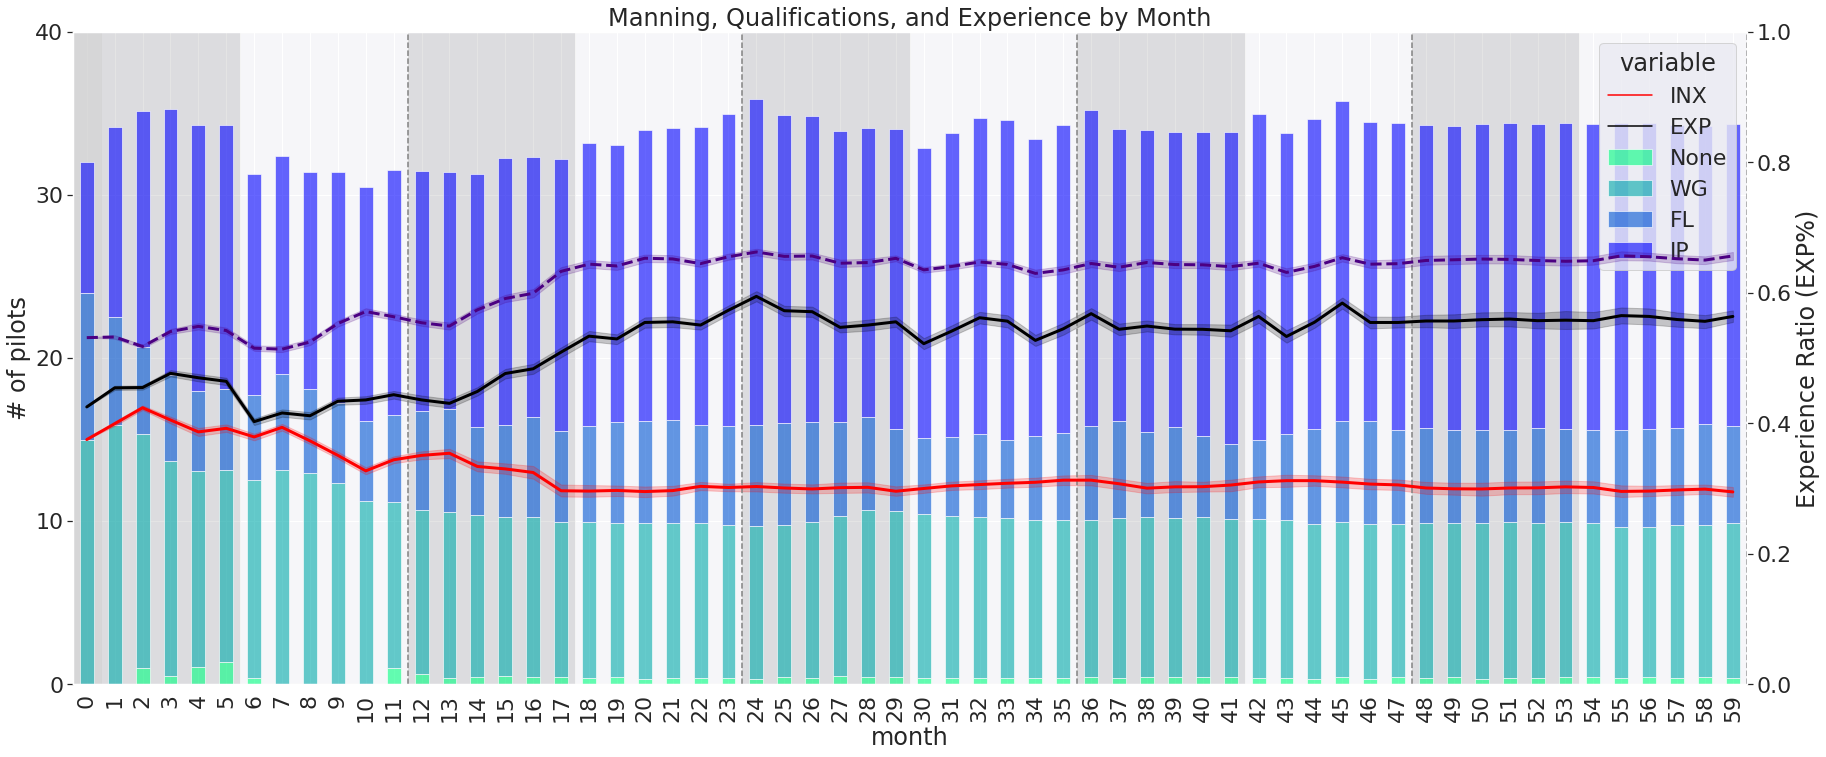

In [132]:
plt.rcParams['figure.figsize'] = (30, 12)
sns.set_theme()
sns.set(font_scale=2)
fig, ax = plt.subplots()
for year in range(1, int(len(quals_df) / 12)+1):
    ax.axvline(year*12 - 0.5, linestyle='--', lw=1.5, c='gray')
    start = (year-1)*12 - 0.5
    ax.axvspan(start, start+6, color='lightgray', alpha=0.6)
    ax.axvspan(start+6, start+12, color='white', alpha=0.6)
ax.axvspan(-0.5, 0.5, color='lightgray', alpha=0.6)
quals_df[['None', 'WG', 'FL', 'IP']].plot(kind='bar', stacked=True, colormap='winter_r', alpha=0.6, ax=ax)
sns.lineplot(data=exp_df, x='month', y='value', hue='variable', ax=ax, linewidth=3, palette=['red', 'black'])
ax2 = ax.twinx()
sns.lineplot(data=exp_df, x='month', y='ratio', ax=ax2, color='indigo', linestyle='--', linewidth=3, alpha=1)
ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticks([0, 10, 20, 30, 40])
ax.set_ylabel('# of pilots')
ax2.set_ylabel('Experience Ratio (EXP%)')
ax.set_title('Manning, Qualifications, and Experience by Month')
ax2.grid(False)

In [133]:
df = pd.DataFrame(np.array([np.array([month for month in run['monthly']['SCM_INX']], dtype='object') for run in many])).melt(var_name='month', value_name='SCM')
df['experience'] = 'INX'
df = pd.concat([df, pd.DataFrame(np.array([np.array([month for month in run['monthly']['SCM_EXP']], dtype='object') for run in many])).melt(var_name='month', value_name='SCM').assign(experience='EXP')])
scm_df = df.explode('SCM')
scm_df

,month,SCM,experience
0,0,5,INX
0,0,3,INX
0,0,8,INX
0,0,6,INX
0,0,3,INX
...,...,...,...
5999,59,11,EXP
5999,59,10,EXP
5999,59,8,EXP
5999,59,7,EXP


In [134]:
scm_df[scm_df['SCM'] > 20]

,month,SCM,experience


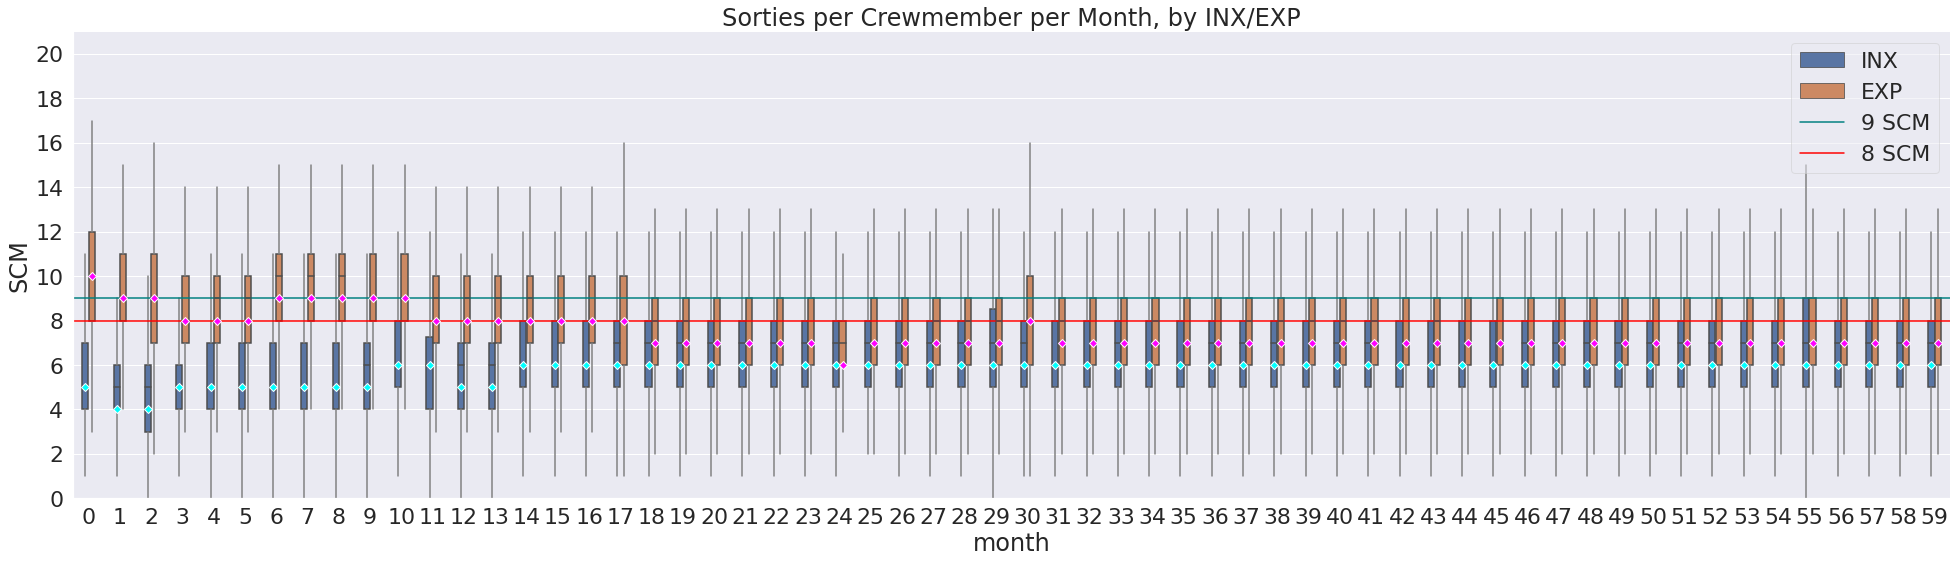

In [135]:
box = sns.catplot(data=scm_df, y='SCM', x='month', hue='experience', kind='box', width=0.4, showmeans=True, showcaps=False, showfliers=False, meanprops={'marker': 'D', 'markeredgecolor': 'white', 'markersize': 5}, whiskerprops={'color': 'grey'}, height=8, aspect=3.5, legend=False)
# == Code below modified from https://stackoverflow.com/questions/63038011/assign-color-of-mean-markers-while-using-seaborn-hue
num_artists = 2*len(quals_df)
num_lines = len(box.ax.lines)
lines_per_artist = num_lines // num_artists
marker_colors = ['cyan', 'magenta']*(num_artists//2)
for i in range(num_artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = marker_colors[i]
    # box.ax.lines[i*lines_per_artist + j].set_edgecolor(col)
    # box.ax.lines[i*lines_per_artist + j].set_facecolor('None')
    # set the marker colors of the corresponding "lines" to the same color
    for j in range(lines_per_artist):
        box.ax.lines[i * lines_per_artist + j].set_markerfacecolor(col)
        box.ax.lines[i * lines_per_artist + j].set_markeredgecolor('white')
# ==
box.ax.axhline(9, color='teal', label='9 SCM')
box.ax.axhline(8, color='red', label='8 SCM')
box.ax.set_yticks(range(0, 21, 2))
box.ax.set_ylim(0, 21)
box.ax.set_title('Sorties per Crewmember per Month, by INX/EXP')
plt.legend(framealpha=0.5)
plt.show()

In [136]:
#  ax = flows[['net_first', 'net_nth']].plot(kind='bar')
#  ax.axhline(0, color='black')
#  ax.set_xlabel('month')
#  ax.set_ylabel('net gain/loss by first v. nth tour')

#  flows[['first_cum', 'nth_cum']].plot(kind='line', ax=ax)

In [137]:
df = pd.DataFrame([row for run in many for row in run['pilot']['TTE'] if row['Absorbable']])
df['EXP year'] = df['EXP month'].floordiv(12)
absorbed_df = df
absorbed_df

,PID,Source,TTE,EXP month,Absorbable,EXP year
0,5,initial WG,30,4,True,0
1,15,initial WG,26,6,True,0
2,4,initial WG,34,8,True,0
3,11,initial WG,27,10,True,0
4,2,initial WG,29,15,True,1
...,...,...,...,...,...,...
1929,47,FTU,27,43,True,3
1930,50,FTU,28,46,True,3
1931,54,FTU,27,49,True,4
1932,55,FTU,30,53,True,4


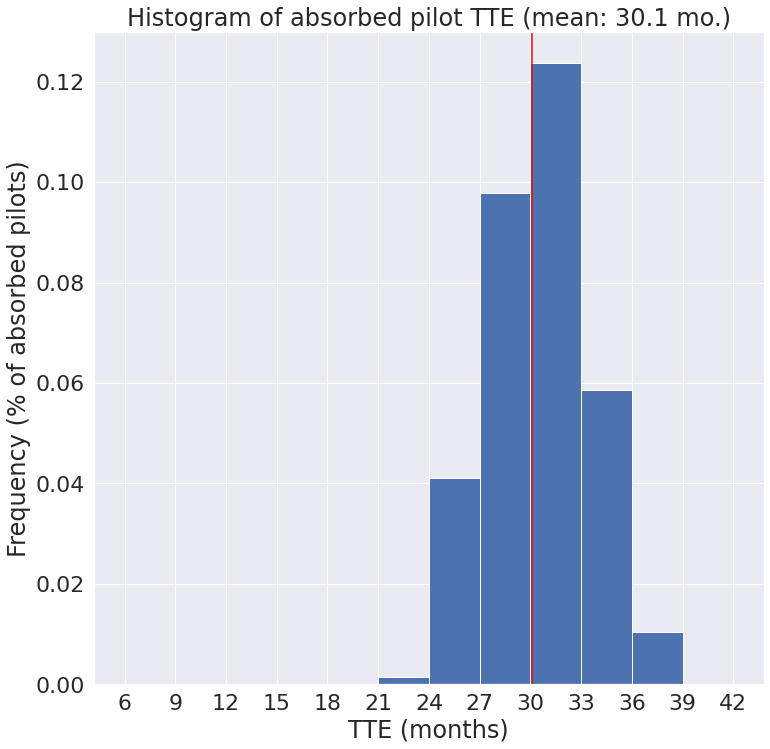

In [138]:
plt.rcParams['figure.figsize'] = (12, 12)
fig, ax = plt.subplots()
absorbed_df['TTE'].plot.hist(bins=range(6, 45, 3), density=True, ax=ax)
ax.axvline(absorbed_df['TTE'].mean(), color='red')
ax.set_xlabel('TTE (months)')
ax.set_ylabel('Frequency (% of absorbed pilots)')
ax.set_title(f'Histogram of absorbed pilot TTE (mean: {absorbed_df["TTE"].mean():.1f} mo.)')
ax.set_xticks(range(6, 45, 3))
plt.show()

<AxesSubplot:ylabel='month'>

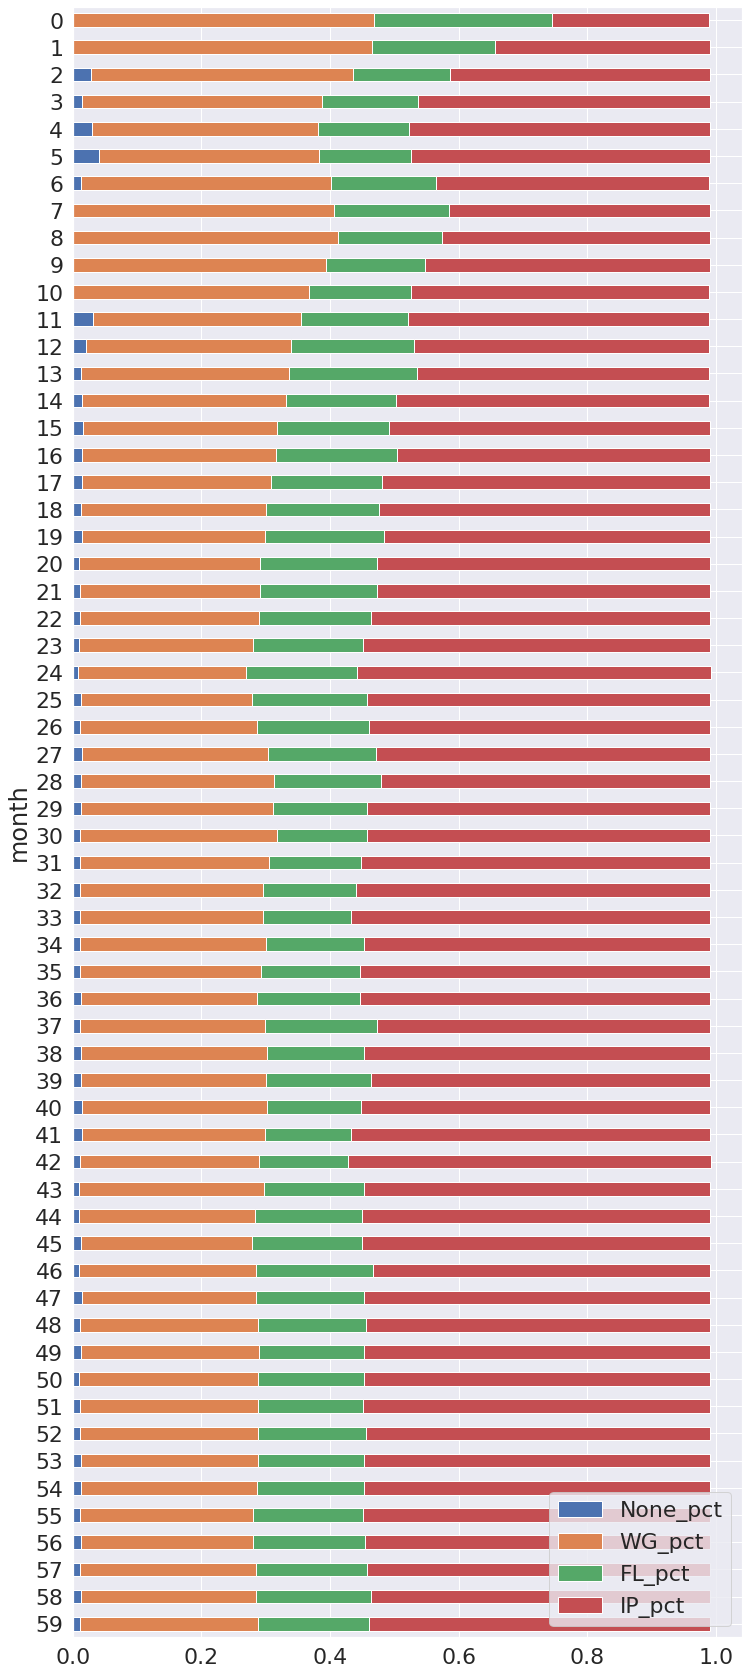

In [139]:
plt.rcParams['figure.figsize'] = (12, 30)
quals_df.loc[::-1, 'None_pct':].plot(kind='barh', stacked=True)

In [140]:
per_year = absorbed_df.groupby('EXP year').size() / num_runs
per_year

EXP year
0    3.80
1    3.62
2    3.28
3    4.24
4    4.07
5    0.33
dtype: float64

In [141]:
mean_absorption = per_year[:int(months_per_run/12)].mean()

<AxesSubplot:title={'center':'Absorption by Year (mean: 3.8 pilots per year)'}, xlabel='EXP year'>

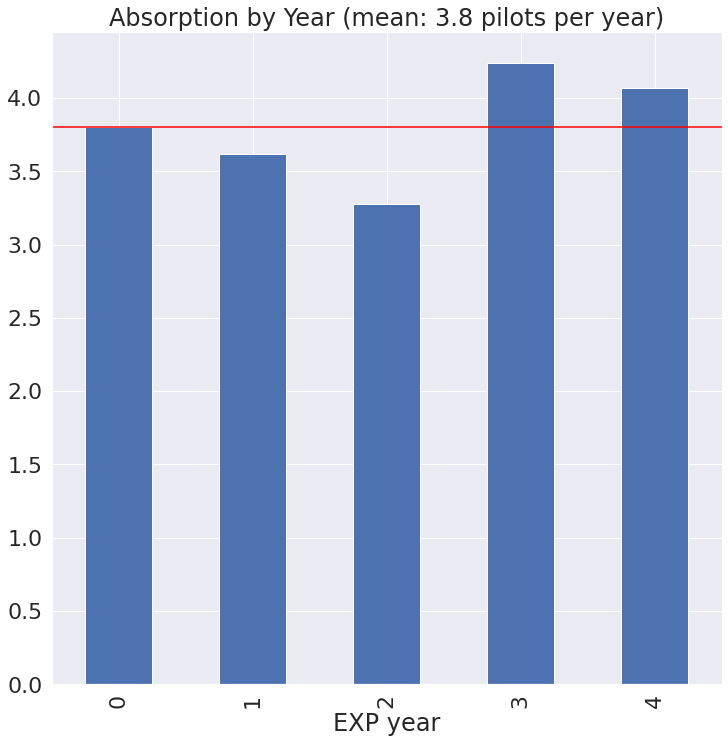

In [142]:
plt.rcParams['figure.figsize'] = (12, 12)
fig, ax = plt.subplots()
ax.axhline(mean_absorption, color='red')
ax.set_title(f'Absorption by Year (mean: {mean_absorption:.1f} pilots per year)')
per_year[:int(months_per_run/12)].plot(ax=ax, kind='bar')